# Representation Learning at the Houses of the Oireachtas in Ireland

Notebook dedicated to run representation learning on the Houses of the Oireachtas' data in Ireland.

This work is based on a Senator Representations' work of the US Congress by Nathaniel Tucker:

https://github.com/knathanieltucker/tf-keras-tutorial/blob/master/SenatorRepresentations.ipynb

The Oireachtas is the legislature of the Republic of Ireland.

The Oireachtas consists of:
- The President of Ireland
- The two houses of the Oireachtas:
    - Dáil Éireann (lower house)
    - Seanad Éireann (upper house)
    
Further info: https://en.wikipedia.org/wiki/Oireachtas

Information regarding the Houses of the Oireachtas is featured on their website, including legislation, and is the copyright of the Houses of the Oireachtas: https://beta.oireachtas.ie/. 

Another interesting resource is https://www.kildarestreet.com/ which is a searchable archive of everything that's been said in the Dáil and all written parliamentary questions since January 2004, everything in the Seanad since September 2002, and all Committee meetings since September 2012.

Open Data from the Houses of the Oireachtas can be accessed via:
https://beta.oireachtas.ie/en/open-data/

This includes a link to the open data APIs via a Swagger UI:
https://api.oireachtas.ie/

A vote in the Houses of the Oireachtas is also called a division. We will be looking at this divisions (votings) table for the house and the Seanad (Senate):

In [1]:
import requests # http://docs.python-requests.org/
from BeautifulSoup import BeautifulSoup
import json
import time
import csv
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
data_path = "data/congress/Ireland"

In [3]:
def get_votings(chamber = 'seanad'):  # chamber: 'seanad' or 'dail' if chamber_type: 'house'
    
    votings_data = []

    table = "divisions" # votings table
    url = 'https://api.oireachtas.ie/v1/{}'.format(table)
    date_start = '1900-01-01'
    date_end = '2017-12-31'
    chamber_type = 'house' # 'committee' or 'house'

    batch = 500
    skip = 0
    limit = skip + batch
    count = 1 # start

    while count > 0:

        params = dict(chamber_type=chamber_type,
                      chamber=chamber, 
                      date_start=date_start, 
                      date_end=date_end,
                      skip=skip, 
                      limit=limit)
        r = requests.get(url, params=params)

        print r.url
        # print "Status Code:", r.status_code
        # print "Headers:", r.headers

        # Add data from this batch
        contents = r.json()

        if 'message' in contents and contents['message'] == 'server error':
            print 'ERROR RETRIEVING DATA'
            return votings_data

        # Results    
        votings = contents['results'][:batch] # in order not to have duplicates
        votings_data.extend(votings)

        # Update count, more to retrieve?
        count = len(votings)
        print 'Number retrieved', count
        # Update skip and limit for query
        skip += batch
        limit += batch

        time.sleep(1)
        
    return votings_data

### Seanad Éireann (upper house)

In [4]:
# seanad_data = get_votings()

In [5]:
# with open('%s/seanad_data.json' % (data_path), 'w') as outfile:
#      json.dump(seanad_data, outfile)

In [6]:
seanad_data = json.load(open('%s/seanad_data.json' % (data_path)))

How many votings in the Senate?

In [7]:
len(seanad_data)

3530

In [8]:
# seanad_data[0]

### Dáil Éireann (lower house)

In [9]:
# dail_data = get_votings(chamber = 'dail')

In [10]:
# with open('%s/dail_data.json' % (data_path), 'w') as outfile:
#      json.dump(dail_data, outfile)

In [11]:
dail_data = json.load(open('%s/dail_data.json' % (data_path)))

In [12]:
len(dail_data)

5000

**Note**

The division count for the Dail is actually 7,329 but the API does only let me retrieve the first 5,000 votings

In [13]:
# dail_data[0]

Verify there is no duplicates:

In [14]:
def verify_no_voting_duplicates(vote_data):
    votes = []
    duplicates = []
    for vote in vote_data:
        uri = vote["division"]["uri"]
        if uri not in votes:
            # print uri
            votes.append(uri)
        else:
            duplicates.append(uri)
    return len(duplicates)

In [15]:
verify_no_voting_duplicates(seanad_data)

0

In [16]:
verify_no_voting_duplicates(dail_data)

0

Get members from the votings:

In [17]:
def get_members(vote_data):
    members = set()
    for vote in vote_data:
        div = vote["division"]
        for outcome, voting in div["tallies"].iteritems():            
            if voting is not None:
                # print voting["showAs"] # Tá (YES), Níl (NO), Staon (Abstention)
                # print len(voting["members"])
                for member in voting["members"]:
                    member = member["member"]
                    #last_name, first_name = member["showAs"].split(",")
                    #first_name = first_name[:-1].strip()
                    #last_name = last_name.strip()
                    member_code = member["memberCode"]
                    # print member_code
                    if member_code is not None:
                        members.add(member_code)
    return members

**Senators**

In [18]:
senators = get_members(seanad_data)

In [19]:
list(senators)[3]

u'Maria-Byrne.S.2016-04-25'

In [20]:
len(senators)

197

**Deputies**

In [21]:
deputies = get_members(dail_data)

In [22]:
list(deputies)[2]

u'Martin-Kenny.D.2016-10-03'

In [23]:
len(deputies)

372

All members:

In [24]:
all_members = senators.union(deputies)

In [25]:
len(all_members)

478

In [26]:
# for v, k in enumerate(set(all_members)):
#     print v, k

In [27]:
# leave the first two blank for padding and not a member
member_to_id = { k: v + 2 for v, k in enumerate(all_members) }

In [28]:
# member_to_id

In [29]:
senator_to_id = { k: v + 2 for v, k in enumerate(senators) }
deputy_to_id = { k: v + 2 for v, k in enumerate(deputies) }

In [30]:
len(senator_to_id), len(deputy_to_id)

(197, 372)

In [31]:
def get_member_id(name, collection):
    name = name.replace(" ", "-").replace(".", "")
    sens = [k for k, v in collection.iteritems() if k is not None and k.startswith(name)]
    if len(sens) > 0:
        return collection[sens[0]]
    return 1

In [32]:
get_member_id('Aideen Hayden', member_to_id)

444

In [33]:
get_member_id('Aideen Hayden', senator_to_id), get_member_id('Aideen Hayden', deputy_to_id)

(133, 1)

**Parties**

In [34]:
def get_member_party(name):
    uri = 'https://beta.oireachtas.ie/en/members/member/%s/' % (name)
    try:
        page = requests.get(uri).text
        # dom = web.Element(page)
        # party = dom.content.split('<p class="bio-text">Party:</p> <p>')[1].split('</p')[0].strip()
        bs = BeautifulSoup(page)
        er = bs.find(text="Party:")
        party = bs.find(text="Party:").findNext('p').contents[0].strip()
    except:
        party = raw_input('For member %s, please input his/her party manually: ' % (name))
    return party

In [35]:
member = list(all_members)[0]

In [36]:
member, get_member_party(member)

(u'Cecilia-Keaveney.D.1996-04-02', u'Fianna F\xe1il')

In [37]:
member = list(all_members)[17]
member, get_member_party(member)

(u"Darragh-O'Brien.D.2007-06-14", u'Fianna F\xe1il')

In [38]:
# member = list(all_members)[21] # Willie-O'Dea.D.1982-03-09
# print member
# get_member_party(member) # prompt: For member Willie-O'Dea.D.1982-03-09, please input his/her party manually

In [39]:
def get_parties(members):

    parties = []
    
    for member in members:
        
        print 'Member', member
    
        parties.append(
            {'member': member.strip(),
             'party': get_member_party(member)})
    
    return parties

In [40]:
# parties = get_parties(all_members)

In [41]:
# with open('%s/parties.json' % (data_path), 'w') as outfile:
#      json.dump(parties, outfile)

In [42]:
parties = json.load(open('%s/parties.json' % (data_path)))

In [43]:
parties[0]

{u'member': u'Cecilia-Keaveney.D.1996-04-02', u'party': u'Fianna F\xe1il'}

In [44]:
parties = { party['member']: party['party'] for party in parties }

In [45]:
set(val for val in parties.values())

{u'Anti-Austerity Alliance - People Before Profit',
 u'Ceann Comhairle',
 u'Fianna F\xe1il',
 u'Fine Gael',
 u'Green Party',
 u'Independent',
 u'Independents 4 Change',
 u'Labour',
 u'Labour Party',
 u'Progressive Democrats',
 u'Renua',
 u'Sinn F\xe9in',
 u'Social Democrats',
 u'Socialist Party',
 u'Solidarity - People Before Profit'}

In [46]:
from collections import Counter
Counter([v for v in parties.values()]).most_common()

[(u'Fianna F\xe1il', 165),
 (u'Fine Gael', 122),
 (u'Independent', 64),
 (u'Labour Party', 45),
 (u'Sinn F\xe9in', 33),
 (u'Green Party', 12),
 (u'Labour', 12),
 (u'Progressive Democrats', 9),
 (u'Solidarity - People Before Profit', 4),
 (u'Independents 4 Change', 3),
 (u'Renua', 3),
 (u'Anti-Austerity Alliance - People Before Profit', 2),
 (u'Social Democrats', 2),
 (u'Socialist Party', 1),
 (u'Ceann Comhairle', 1)]

**Display names: Last name, Party**

In [47]:
# Not all members will appear on the votings 
member_id_to_displayname = {}
senator_id_to_displayname = {}
deputy_id_to_displayname = {}
for member_code in set(all_members):
    member_id = member_to_id[member_code]
    name = member_code
    party = parties[name]
    if name is not None and '.' in name:
        name = name.split('.')[0].split('-')[-1] # last name
    if party is not None:
        name = name + ", " + party
    member_id_to_displayname[member_id] = name
    if member_code in senators:
        senator_id = senator_to_id[member_code]
        senator_id_to_displayname[senator_id] = name
    if member_code in deputies:
        deputy_id = deputy_to_id[member_code]
        deputy_id_to_displayname[deputy_id] = name

In [48]:
# member_id_to_displayname

In [49]:
member_id_to_displayname[2]

u'Keaveney, Fianna F\xe1il'

In [50]:
get_member_id('Cecilia Keaveney', member_to_id)

2

In [51]:
# senator_id_to_displayname

In [52]:
senator_id_to_displayname[3]

u'B\xfarca, Green Party'

In [53]:
# deputy_id_to_displayname

In [54]:
deputy_id_to_displayname[4]

u'Kenny, Sinn F\xe9in'

In [55]:
len(member_id_to_displayname), len(senator_id_to_displayname), len(deputy_id_to_displayname)

(478, 197, 372)

**Extracting sponsors and members against a bill**

The following function encapsulates how to extract sponsors and members against a bill based on a line of text manually inputed and in several formats:

In [56]:
# Sponsors and members against a Bill are specified in a text line where we will extract:
# 2 members that sponsored the bill
# 2 members that opposed to the bill
def get_sponsors(tellers_data, collection):
    
    # print tellers_data
    
    sp_first, sp_second, ag_first, ag_second = None, None, None, None
    
    if ";" in tellers_data:
        
        tellers = tellers_data.split(";")
        
        for teller in tellers:
            
            if teller.strip() == "":
                continue
            if "Tellers:" in teller:
                teller = teller.split("Tellers:")[1].strip()
            elif ":" in teller:
                teller = teller.split(":")[1].strip()

            if "," in teller:
                values = teller.split(",")
            elif ":" in teller:
                values = teller.split(":")
            else:
                #print "Bad format"
                continue
            if len(values) != 2:
                #print "BAD format"
                continue
                
            support, members = values

            if "Senators" in members:
                members = members.split("Senators")
                members = members[-1]
            elif "Deputies" in members:
                members = members.split("Deputies")
                members = members[-1]
                
            if " and" in members:
                members = members.split(" and")
            elif "and " in members:
                members = members.split("and ")
            elif "an d":
                members = members.split("an d")
            else:
                members = members.split("and")
            
            if len(members) > 1:
                first_member, second_member = members[:2]
                first_member = first_member.strip()
                second_member = second_member.strip()
            else:
                first_member = members[0]
                first_member = first_member.strip()
                second_member = "None"
            
            support = support.strip()

            if support.encode('utf-8') == str('T\xc3\xa1'):
                sp_first = get_member_id(first_member, collection)
                sp_second = get_member_id(second_member, collection)
                # print "Sponsors", first_member, sp_first, second_member, sp_second
                
            elif support.encode('utf-8') == str('N\xc3\xadl'):
                ag_first = get_member_id(first_member, collection)
                ag_second = get_member_id(second_member, collection)
                # print "Against", first_member, ag_first, second_member, ag_second
                
    return sp_first, sp_second, ag_first, ag_second 

**Votings**

In [57]:
def get_vote_data(data, collection_to_ids, display_names):

    votings = []
    added, not_added = [], []

    for vote in data:

        div = vote["division"]
        date = datetime.strptime(div["date"], '%Y-%m-%d')
        #outcome = div["outcome"] # Carried, Lost, _
        #print div["isBill"]
        #print div["category"]
        #print div["chamber"]["showAs"]
        #print div["debate"]["showAs"]

        # Bill sponsors
        sponsors = get_sponsors(div["tellers"], collection_to_ids)

        if None in sponsors or sponsors == (1, 1, 1, 1): # Votings that could not be added
            
            not_added.append(date)
            
        else:

            sponsor, cosponsor, against, coagainst = sponsors

            tallies = div["tallies"]

            if tallies["taVotes"] is not None:
                
                for member in tallies["taVotes"]["members"]:
                    member = member["member"]
                    name = member["showAs"]
                    last_name = name.split(',')[0]
                    #uri = member["uri"]
                    #short = member["memberCode"]
                    if member["memberCode"] is not None:
                        member_id = collection_to_ids[member["memberCode"]]
                        party = parties[member["memberCode"]]
                        display_names[member_id] = last_name + ", " + party # replace names with utf8 encoding names
                        votings.append((1, member_id, [sponsor, cosponsor], [against, coagainst])) 

            if tallies["nilVotes"] is not None:
                
                for member in tallies["nilVotes"]["members"]:
                    member = member["member"]
                    name = member["showAs"]
                    last_name = name.split(',')[0]
                    if member["memberCode"] is not None:
                        member_id = collection_to_ids[member["memberCode"]]
                        party = parties[member["memberCode"]]
                        display_names[member_id] = last_name + ", " + party
                        votings.append((0, member_id, [sponsor, cosponsor], [against, coagainst]))   

            added.append(date)
            
    return votings, added, not_added

In [58]:
# Seanad votings

seanad_votings, added, not_added = get_vote_data(seanad_data, senator_to_id, senator_id_to_displayname)

In [59]:
# senator_id_to_displayname

In [60]:
len(seanad_votings), len(added), len(not_added)

(73749, 1771, 1759)

In [61]:
float(len(added)) / (len(added) + len(not_added))

0.501699716713881

On 50% of the bills we were able to extract the sponsors, co-sponsors and members against the votings of those bills. That resulted in more than ~73K individual votes for these bills in the Seanad.

In [62]:
# seanad_votings

In [63]:
# A particular voting for a bill
seanad_votings[0]

(1, 100, [190, 117], [104, 90])

In [64]:
added[0]

datetime.datetime(2017, 12, 5, 0, 0)

In [65]:
min(added), max(added)

(datetime.datetime(1964, 2, 26, 0, 0), datetime.datetime(2017, 12, 5, 0, 0))

In [66]:
min(not_added), max(not_added)

(datetime.datetime(1923, 2, 21, 0, 0), datetime.datetime(2009, 6, 25, 0, 0))

In [67]:
def plot_bills_analysed(a, n):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=100)
    ax0, ax1 = axes.flatten()

    ax0.hist(a, bins='auto', color='b')
    ax0.set_title('Frequency of bills added')
    
    ax1.hist(n, bins='auto', color='r')
    ax1.set_title('Frequency of bills NOT added')

    fig.tight_layout()
    plt.show()

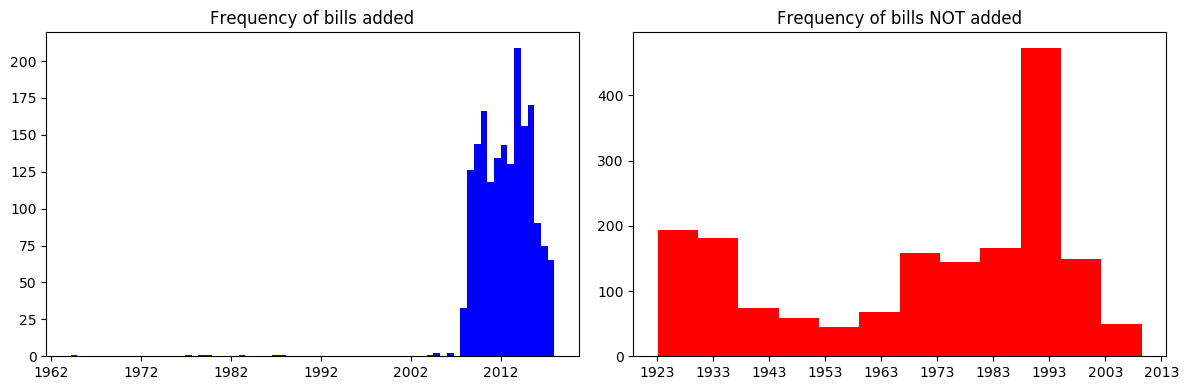

In [68]:
plot_bills_analysed(added, not_added)

In [69]:
# Votings gathered from those bills WITH a Sponsor (all of them, if not we disregard it)
Counter([s[1] == 1 for s in seanad_votings])

Counter({False: 73749})

In [70]:
# Votings gathered from those bills WITH and WITHOUT Co-ponsors
Counter([s[2][0] == 1 for s in seanad_votings]), Counter([s[2][1] == 1 for s in seanad_votings])

(Counter({False: 69877, True: 3872}), Counter({False: 67207, True: 6542}))

In [71]:
# Votings gathered from those bills WITH and WITHOUT members Against
Counter([s[3][0] == 1 for s in seanad_votings]), Counter([s[3][1] == 1 for s in seanad_votings])

(Counter({False: 69795, True: 3954}), Counter({False: 67990, True: 5759}))

In [72]:
def plot_votings_analysed(v):

    plt.figure(figsize=(12, 4), dpi=100)
    
    values = {}
    values.setdefault(True, [])
    values.setdefault(False, [])
    labels = []
    
    c = Counter([s[1] == 1 for s in v]).most_common()
    values[True].append(0)
    values[False].append(c[False][1])
    labels.append('Sponsor')
    
    c = Counter([s[2][0] == 1 for s in v]).most_common()
    values[True].append(c[True][1])
    values[False].append(c[False][1])
    labels.append('Co-sponsor 1')
    c = Counter([s[2][1] == 1 for s in v]).most_common()
    values[True].append(c[True][1])
    values[False].append(c[False][1])
    labels.append('Co-sponsor 2')
    
    c = Counter([s[3][0] == 1 for s in v]).most_common()
    values[True].append(c[True][1])
    values[False].append(c[False][1])
    labels.append('Against 1')
    c = Counter([s[3][1] == 1 for s in v]).most_common()
    values[True].append(c[True][1])
    values[False].append(c[False][1])
    labels.append('Against 2')

    plt.bar(range(1, 6), values[False], width=0.4, color='b', align='center')
    bars = plt.bar(np.arange(1, 6) + 0.4, values[True], width=0.4, color='r', align='center')
    for bar in bars:
        h = bar.get_height()
        if h == 0:
            continue
        plt.text(bar.get_x() + bar.get_width() / 5, h * 1.25, str('{}'.format(h)))
    plt.xticks(range(1, 6), labels)
    
    plt.title('Votings analysed and NOT analysed from the bills extracted')

    plt.show()

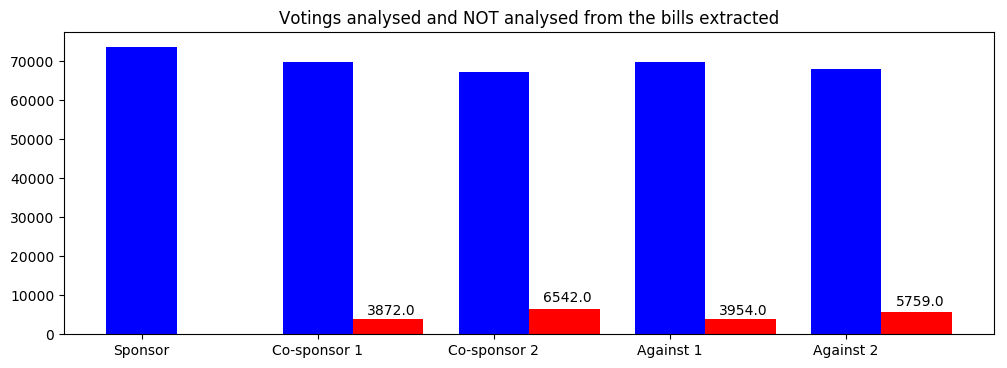

In [73]:
plot_votings_analysed(seanad_votings)

From the bills extracted at the Seanad, most of them contain co-sponsors and members against

In [74]:
# Dail votings

dail_votings, added, not_added = get_vote_data(dail_data, deputy_to_id, deputy_id_to_displayname)

In [75]:
len(dail_votings), len(added), len(not_added)

(102252, 917, 4083)

In [76]:
# dail_votings

In [77]:
# A particular vote
dail_votings[0]

(1, 350, [272, 332], [252, 62])

In [78]:
float(len(added)) / (len(added) + len(not_added))

0.1834

Not even 20% of the votings were extracted but still resulted in more than 150K individual votes in the Dail

In [79]:
min(added), max(added)

(datetime.datetime(1982, 5, 4, 0, 0), datetime.datetime(2017, 11, 30, 0, 0))

In [80]:
min(not_added), max(not_added)

(datetime.datetime(1940, 5, 22, 0, 0), datetime.datetime(2014, 11, 20, 0, 0))

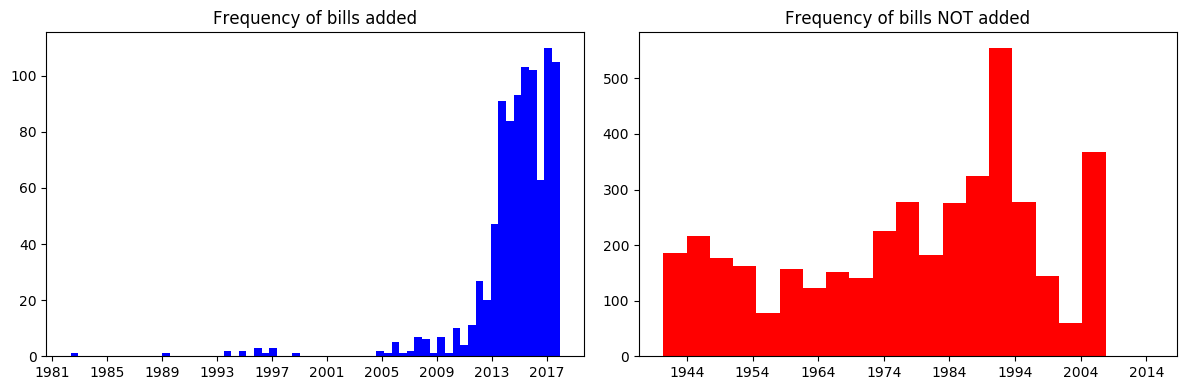

In [81]:
plot_bills_analysed(added, not_added)

In [82]:
Counter([s[1] == 1 for s in dail_votings])

Counter({False: 102252})

In [83]:
Counter([s[2][0] == 1 for s in dail_votings]).most_common()

[(False, 100332), (True, 1920)]

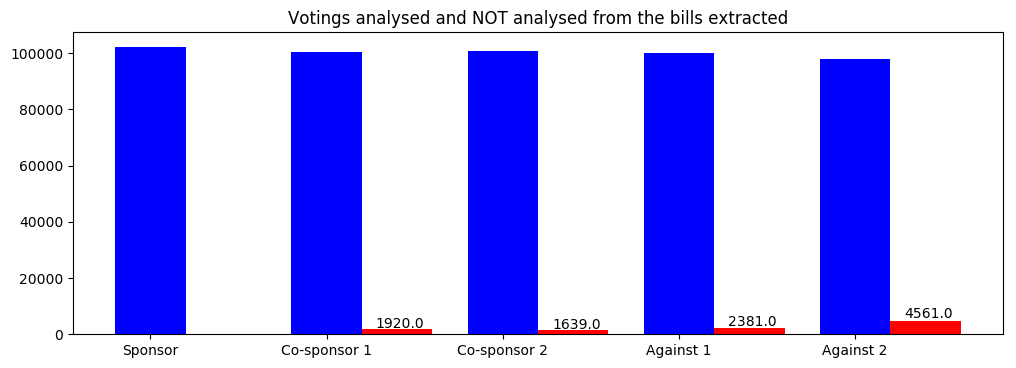

In [84]:
plot_votings_analysed(dail_votings)

Total of individual votes extracted per house:

In [85]:
'Seanad votings {:,}'.format(len(seanad_votings)), 'Dail votings {:,}'.format(len(dail_votings))

('Seanad votings 73,749', 'Dail votings 102,252')

### Senate votings

~73 examples of (vote, senator voting, sponsor, cosponsor, against, coagainst) tuples

In [86]:
y = [d[0] for d in seanad_votings]

In [87]:
# len(y)
Counter(y)

Counter({0: 35926, 1: 37823})

In [88]:
# Padding or cropping
# Not needed as all the votes have the same numer of sponsors (2) and against (2)
limit = 2
def pad_or_crop(lst, l=limit):
    return (lst + [0] * l)[:limit]

In [89]:
x_1 = np.array(map(lambda x: x[1], seanad_votings))
x_2 = np.array(map(lambda x: pad_or_crop(x[2]), seanad_votings))
x_3 = np.array(map(lambda x: pad_or_crop(x[3]), seanad_votings))
x = [x_1, x_2, x_3]

In [90]:
# len(x)

In [91]:
# we add in padding and unknown senators
senator_id_to_displayname[0] = '<PAD>'
senator_id_to_displayname[1] = '<NOT A SENATOR>'

In [92]:
# senator_id_to_displayname

In [93]:
# this gives us how many representations:
len(senator_id_to_displayname)

199

In [94]:
# we again need to write down the metadata
with open('%s/senator_metadata.csv' % (data_path), 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    for key, value in sorted(senator_id_to_displayname.items()):
        writer.writerow([value.encode('utf8')])

In [95]:
# finally we build our model
from keras.layers import concatenate
from keras.layers import Dense, Input, Flatten
from keras.layers import MaxPooling1D, Embedding

embedding_layer = Embedding(len(senator_id_to_displayname), 100)

# train a 1D convnet with global maxpooling
voting = voting_input = Input(shape=(1,), dtype='int32')
voting = embedding_layer(voting)
voting = Dense(32, activation='relu')(voting)
voting = Dense(32, activation='relu')(voting)

sponsor = sponsor_input = Input(shape=(limit,), dtype='int32')
sponsor = embedding_layer(sponsor)
sponsor = MaxPooling1D(limit)(sponsor)
sponsor = Dense(32, activation='relu')(sponsor)
sponsor = Dense(32, activation='relu')(sponsor)

cosponsor = cosponsor_input = Input(shape=(limit,), dtype='int32')
cosponsor = embedding_layer(cosponsor)
cosponsor = MaxPooling1D(limit)(cosponsor)
cosponsor = Dense(32, activation='relu')(cosponsor)
cosponsor = Dense(32, activation='relu')(cosponsor)

combined = concatenate([voting, sponsor, cosponsor])
combined = Dense(32, activation='relu')(combined)
combined = Dense(1, activation='sigmoid')(combined)

Using TensorFlow backend.


In [96]:
from keras.models import Model
from keras.callbacks import TensorBoard

model = Model([voting_input, sponsor_input, cosponsor_input], combined)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

embedding_metadata = {
    embedding_layer.name: '../senator_metadata.csv'
}

model.fit([x_1, x_2, x_3], np.array(y).reshape(-1, 1, 1),
          batch_size=128,
          epochs=10,
          validation_split=0.2,
          callbacks=[TensorBoard(log_dir='%s/senator_reps' % (data_path), 
                                 embeddings_freq=1,
                                 embeddings_metadata=embedding_metadata)])

Train on 58999 samples, validate on 14750 samples
Epoch 1/10
58999/58999 [==============================] - 4s 66us/step - loss: 0.2164 - acc: 0.9067 - val_loss: 0.2033 - val_acc: 0.9393
Epoch 2/10
58999/58999 [==============================] - 3s 55us/step - loss: 0.1375 - acc: 0.9454 - val_loss: 0.2274 - val_acc: 0.9500
Epoch 3/10
58999/58999 [==============================] - 4s 63us/step - loss: 0.1317 - acc: 0.9483 - val_loss: 0.2100 - val_acc: 0.9459
Epoch 4/10
58999/58999 [==============================] - 3s 53us/step - loss: 0.1269 - acc: 0.9500 - val_loss: 0.2369 - val_acc: 0.9459
Epoch 5/10
58999/58999 [==============================] - 3s 55us/step - loss: 0.1240 - acc: 0.9515 - val_loss: 0.2270 - val_acc: 0.9468
Epoch 6/10
58999/58999 [==============================] - 4s 61us/step - loss: 0.1208 - acc: 0.9521 - val_loss: 0.2397 - val_acc: 0.9389
Epoch 7/10
58999/58999 [==============================] - 4s 67us/step - loss: 0.1178 - acc: 0.9531 - val_loss: 0.2235 - val_acc

In data/congress/Ireland, launch TensorBoard:
    
> $ tensorboard --logdir=senator_reps/

Go to TensorBoard:

> http://localhost:6006/#projector
        
In TensorBoard, we can look at the representations created in our model using t-SNE or PCA.

### Dail votings

~100K examples of (vote, senator voting, sponsor, cosponsor, against, coagainst) tuples.

In [97]:
y = [d[0] for d in dail_votings]

In [98]:
# len(y)
Counter(y)

Counter({0: 49038, 1: 53214})

In [99]:
x_1 = np.array(map(lambda x: x[1], dail_votings))
x_2 = np.array(map(lambda x: pad_or_crop(x[2]), dail_votings))
x_3 = np.array(map(lambda x: pad_or_crop(x[3]), dail_votings))
x = [x_1, x_2, x_3]

In [100]:
# we add in padding and unknown senators
deputy_id_to_displayname[0] = '<PAD>'
deputy_id_to_displayname[1] = '<NOT A DEPUTY>'

In [101]:
# deputy_id_to_displayname

In [102]:
len(deputy_id_to_displayname)

374

In [103]:
# we again need to write down the metadata
with open('%s/deputy_metadata.csv' % (data_path), 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    for key, value in sorted(deputy_id_to_displayname.items()):
        writer.writerow([value.encode('utf8')])

In [104]:
# finally we build our model
from keras.layers import concatenate
from keras.layers import Dense, Input, Flatten
from keras.layers import MaxPooling1D, Embedding

embedding_layer = Embedding(len(deputy_id_to_displayname), 100)

# train a 1D convnet with global maxpooling
voting = voting_input = Input(shape=(1,), dtype='int32')
voting = embedding_layer(voting)
voting = Dense(32, activation='relu')(voting)
voting = Dense(32, activation='relu')(voting)

sponsor = sponsor_input = Input(shape=(limit,), dtype='int32')
sponsor = embedding_layer(sponsor)
sponsor = MaxPooling1D(limit)(sponsor)
sponsor = Dense(32, activation='relu')(sponsor)
sponsor = Dense(32, activation='relu')(sponsor)

cosponsor = cosponsor_input = Input(shape=(limit,), dtype='int32')
cosponsor = embedding_layer(cosponsor)
cosponsor = MaxPooling1D(limit)(cosponsor)
cosponsor = Dense(32, activation='relu')(cosponsor)
cosponsor = Dense(32, activation='relu')(cosponsor)

combined = concatenate([voting, sponsor, cosponsor])
combined = Dense(32, activation='relu')(combined)
combined = Dense(1, activation='sigmoid')(combined)

In [105]:
from keras.models import Model
from keras.callbacks import TensorBoard

model = Model([voting_input, sponsor_input, cosponsor_input], combined)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

embedding_metadata = {
    embedding_layer.name: '../deputy_metadata.csv'
}

model.fit([x_1, x_2, x_3], np.array(y).reshape(-1, 1, 1),
          batch_size=128,
          epochs=10,
          validation_split=0.2,
          callbacks=[TensorBoard(log_dir='%s/deputy_reps' % (data_path), 
                                 embeddings_freq=1,
                                 embeddings_metadata=embedding_metadata)])

Train on 81801 samples, validate on 20451 samples
Epoch 1/10
81801/81801 [==============================] - 6s 69us/step - loss: 0.2329 - acc: 0.8995 - val_loss: 0.3895 - val_acc: 0.8540
Epoch 2/10
81801/81801 [==============================] - 6s 73us/step - loss: 0.1572 - acc: 0.9408 - val_loss: 0.3552 - val_acc: 0.8746
Epoch 3/10
81801/81801 [==============================] - 5s 66us/step - loss: 0.1463 - acc: 0.9461 - val_loss: 0.3944 - val_acc: 0.8650
Epoch 4/10
81801/81801 [==============================] - 6s 73us/step - loss: 0.1325 - acc: 0.9515 - val_loss: 0.4241 - val_acc: 0.8517
Epoch 5/10
81801/81801 [==============================] - 6s 68us/step - loss: 0.1125 - acc: 0.9581 - val_loss: 0.4889 - val_acc: 0.8485
Epoch 6/10
81801/81801 [==============================] - 6s 71us/step - loss: 0.1005 - acc: 0.9626 - val_loss: 0.4825 - val_acc: 0.8489
Epoch 7/10
81801/81801 [==============================] - 6s 72us/step - loss: 0.0952 - acc: 0.9636 - val_loss: 0.4658 - val_acc

In data/congress/Ireland, launch TensorBoard:
    
> $ tensorboard --logdir=deputy_reps/

### Utils

In [106]:
print '\xc3\xa1' == str('á')
print str('á').decode('utf-8').encode('utf-8')
print str('á').decode('utf-8').encode('utf-8') == str('\xc3\xa1')
print str('Tá').decode('utf-8').encode('utf-8') == str('T\xc3\xa1')
print str('Níl').decode('utf-8').encode('utf-8') == str('N\xc3\xadl')

True
á
True
True
True
